# Diabetes

In [5]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
from io import BytesIO
import urllib.request as urllib2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import time
from sklearn.cluster import KMeans

In [2]:
r = urllib2.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip").read()
file = ZipFile(BytesIO(r))
diabetes_df = file.open("dataset_diabetes/diabetic_data.csv")
map_id_df = file.open("dataset_diabetes/IDs_mapping.csv")

diabetes_df = pd.read_csv(diabetes_df)
map_id_df = pd.read_csv(map_id_df)

In [3]:
# replace ? with NaN
diabetes_df=diabetes_df.replace('?', np.nan)
diabetes_df=diabetes_df.replace('>30', 'YES')
diabetes_df=diabetes_df.replace('<30', 'YES')
diabetes_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,YES
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,YES
101762,443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [4]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [5]:
diabetes_df.readmitted.value_counts()

NO     54864
YES    46902
Name: readmitted, dtype: int64

In [6]:
diabetes_df.admission_type_id.value_counts()

1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64

In [7]:
diabetes_df.diag_1.value_counts()

428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
817       1
61        1
148       1
870       1
V51       1
Name: diag_1, Length: 716, dtype: int64

In [8]:
diabetes_df.weight.value_counts()

[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64

In [4]:
# dropping columns which are not necessary while clustering
diabetes_df_dropped = diabetes_df.drop(['weight','payer_code','encounter_id','patient_nbr', 'medical_specialty', 'examide',  'citoglipton'], axis = 1)

In [10]:
diabetes_df_dropped

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,YES
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),1,3,7,3,51,0,16,...,No,Down,No,No,No,No,No,Ch,Yes,YES
101762,AfricanAmerican,Female,[80-90),1,4,5,5,33,3,18,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,Caucasian,Male,[70-80),1,1,7,1,53,0,9,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,Caucasian,Female,[80-90),2,3,7,10,45,2,21,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [5]:
# dropping Nan values
diabetes_df_dropped=diabetes_df_dropped.dropna()

In [12]:
diabetes_df_dropped.shape

(98053, 43)

In [6]:
diabetes_df_categorical = diabetes_df_dropped.select_dtypes(include='object').columns
diabetes_df_categorical

Index(['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [7]:
le=LabelEncoder()
le_list=[]
for features in diabetes_df_categorical:
  diabetes_df_dropped[features] = le.fit_transform(diabetes_df_dropped[features])

In [8]:
scaled_diabetes_data = StandardScaler().fit_transform(diabetes_df_dropped.iloc[:,:-1].values)
diabetes_df_dropped.iloc[:,:-1] = pd.DataFrame(scaled_diabetes_data, index=diabetes_df_dropped.iloc[:,:-1].index, columns=diabetes_df_dropped.iloc[:,:-1].columns)

In [9]:
readmitted_yes= diabetes_df_dropped[diabetes_df_dropped.readmitted==1]
readmitted_no=diabetes_df_dropped[diabetes_df_dropped.readmitted==0]

In [10]:
readmitted_no=readmitted_no.drop('readmitted', axis=1)
readmitted_yes=readmitted_yes.drop('readmitted', axis=1)

Problem 4 kmeans algorithm

In [18]:
#kmeans algorithm ck
import numpy as np
import random
import math

def eud(tup1,tup2):
  eu_dist = np.linalg.norm(np.array(tup1) - np.array(tup2))
  return eu_dist

def c_k(d,dist,k,r):
  c = main(d,dist,k,r)
  temp_v = 'v'
  temp_b = 'b'
  centroids = [a[temp_v] for key, a in c.items() if temp_v in a]
  clusters = [a[temp_b] for key, a in c.items() if temp_b in a]
  return centroids,clusters

def main(d,dist,k,thresh): 
  i = 0
  j = 1
  idx = 0
  prev_cen = list()
  tow = list()
  compare = float('inf')
  dist =list()
  cen_values= defaultdict(dict)
  cen_values['j'] = defaultdict(dict)
  c = cen_values['j']
  rand_centroids = random.choices(d,k=k)
  for j in range(1,k+1):
    c[j]= {'v': rand_centroids[j-1], 'b':list()}
  while(True):
    tow = list()
    for data_point in d:
      j=1
      while(j<=k):
        dist.append(eud(c[j]['v'],data_point))
        j+=1
      idx = dist.index(np.min(dist)) 
      c[idx+1]['b'].append(data_point)
      dist = list()
    if compare < thresh:
      break
    for j in range(1,k+1):
      n = len(c[j]['b'])
      prev_cen = c[j]['v']
      if n!=0:
        c[j]['v'] = (*map(lambda x: x/n, (*map(sum, zip(*c[j]['b'])),)),)
      c[j]['b']=list()
      diff_c = np.subtract(prev_cen,c[j]['v'])
      tow.append(math.sqrt(abs((np.dot(tuple(reversed(diff_c)),diff_c)))/k))
    compare = sum(tow)  
  return c

In [19]:
set_no_readmit= set(map(tuple,np.array(readmitted_no)))
for k in range(2,6):
  total_error = list()
  dist=list()
  for _ in range(0,20):
    error = []
    sum_error =[]
    centroids,clusters = c_k(np.array(diabetes_df_dropped)[:,:-1],dist,k,10) 
    no = np.zeros(shape = (1,k))
    yes = np.zeros(shape = (1,k))
    for s in range(0,k):
      for p in range(0,len(clusters[s])):
        if tuple(clusters[s][p]) in set_no_readmit:
          no[0][s]+=1
        else:
          yes[0][s]+=1
      if (no[0][s]+yes[0][s])!=0:
        if no[0][s] >= yes[0][s]:
          temp =yes[0][s]/(no[0][s]+yes[0][s])
        else:
          temp = no[0][s]/(no[0][s]+yes[0][s])
      else:
        temp=0
      error.append(temp)
    sum_error  = sum(error)/k
    total_error.append(sum_error)
  plt.boxplot(total_error)
  plt.xlabel(f'cluster K= {k}')
  plt.ylabel('Error rate')
  plt.title('K means Error Boxplot of diabetes data')
  plt.savefig(f'Boxplot c_k {k} of diabetes data')
  plt.clf()

183.2329137325287


<Figure size 432x288 with 0 Axes>

problem 5 sse diabetes


In [20]:
import numpy as np
import random
import math
from collections import defaultdict
def eud(tup1,tup2):
  eu_dist = np.linalg.norm(np.array(tup1) - np.array(tup2))
  return eu_dist

def c_ksse(d,dist,k,r):
  c = main_sse(d,dist,k,r)
  temp_v = 'v'
  temp_b = 'b'
  centroids = [a[temp_v] for key, a in c.items() if temp_v in a]
  clusters = [a[temp_b] for key, a in c.items() if temp_b in a]
  return centroids,clusters

def main_sse(d,dist,k,thresh): 
  i = 0
  j = 1
  idx = 0
  prev_sse= list()
  curr_sse= float('inf')
  dist =list()
  cen_values= defaultdict(dict)
  cen_values['j'] = defaultdict(dict)
  c = cen_values['j']
  for j in range(1,k+1):
    rand_centroids = random.choices(d,k=k)
    c[j]= {'v': rand_centroids[j-1], 'b':list(), 'sse': list()}
  while(True):
    for data_point in d:
      j=1
      while(j<=k):
        dist.append(eud(c[j]['v'],data_point))
        j+=1
      min = np.min(dist)
      idx = dist.index(min) 
      c[idx+1]['sse'].append(min)
      c[idx+1]['b'].append(data_point)
      dist = list()
    for j in range(1,k+1):
      prev_sse.append(sum(c[j]['sse'])/len(c[j]['sse']))
    all_prev_sse = sum(prev_sse)/k
    prev_sse =list()
    if curr_sse - all_prev_sse < thresh:
      break
    else:
      curr_sse= all_prev_sse
    for j in range(1,k+1):
      n = len(c[j]['b'])
      if n!=0:
        c[j]['v'] = (*map(lambda x: x/n, (*map(sum, zip(*c[j]['b'])),)),)
      c[j]['sse']=list()
      c[j]['b']=list()
  return c

In [21]:
set_no_readmit= set(map(tuple,np.array(readmitted_no)))
for k in range(2,6):
  total_error = list()
  dist=list()
  for _ in range(0,20):
    error = []
    sum_error =[]
    centroids,clusters = c_ksse(np.array(diabetes_df_dropped)[:,:-1],dist,k,1) 
    no = np.zeros(shape = (1,k))
    yes = np.zeros(shape = (1,k))
    for s in range(0,k):
      for p in range(0,len(clusters[s])):
        if tuple(clusters[s][p]) in set_no_readmit:
          no[0][s]+=1
        else:
          yes[0][s]+=1
      if (no[0][s]+yes[0][s])!=0:
        if no[0][s] >= yes[0][s]:
          temp =yes[0][s]/(no[0][s]+yes[0][s])
        else:
          temp = no[0][s]/(no[0][s]+yes[0][s])
      else:
        temp=0
      error.append(temp)
    sum_error  = sum(error)/k
    total_error.append(sum_error)
  plt.boxplot(total_error)
  plt.xlabel(f'cluster K= {k}')
  plt.ylabel('Error rate')
  plt.title('K means SSE Error Boxplot of diabetes data')
  plt.savefig(f'Boxplot c_ksse{k} of diabetes data')
  plt.clf()

<Figure size 432x288 with 0 Axes>

Problem 6 k means ++ 

In [35]:
# kmeans++ algorithm 
import numpy as np
import random
import math

def eud(tup1,tup2):
  eu_dist = np.linalg.norm(np.array(tup1) - np.array(tup2))
  return eu_dist

def c_k_plus_plus(d,dist,k,r):
  c = main_plus_plus(d,dist,k,r)
  temp_v = 'v'
  temp_b = 'b'
  centroids = [a[temp_v] for key, a in c.items() if temp_v in a]
  clusters = [a[temp_b] for key, a in c.items() if temp_b in a]
  return centroids,clusters

def main_plus_plus(d,dist,k,thresh): 
  i = 0
  j = 1
  idx = 0
  prev_cen = list()
  tow = list()
  compare = float('inf')
  dist =list()
  cen_values= defaultdict(dict)
  cen_values['j'] = defaultdict(dict)
  c = cen_values['j']
  first_cent = random.choice(d)
  c[1]['v'] = first_cent
  c[1]['b'] = list()
  for j in range(1,k):
    for i in range(1,j+1):
      dist_probability = np.array([np.linalg.norm(np.array(d) - c[i]['v'],axis=1)**2]).T
    row_sum = np.min(dist_probability,axis=1)
    row_sum = row_sum/sum(row_sum)
    c[j+1] = {'v':np.array(d)[np.random.choice(len(row_sum),p = row_sum)],'b':list()}
  while(True):
    tow = list()
    for data_point in d:
      dist = list()
      j=1
      while(j<=k):
        dist.append(eud(c[j]['v'],data_point))
        j+=1
      idx = dist.index(np.min(dist)) 
      c[idx+1]['b'].append(data_point)
    if compare < thresh:
      break
    for j in range(1,k+1):
      n = len(c[j]['b'])
      prev_cen = c[j]['v']
      if n!=0:
        c[j]['v'] = (*map(lambda x: x/n, (*map(sum, zip(*c[j]['b'])),)),)
      c[j]['b']=list()
      diff_c = np.subtract(prev_cen,c[j]['v'])
      tow.append(math.sqrt(abs((np.dot(tuple(reversed(diff_c)),diff_c)))/k))
    compare = sum(tow)  
  return c

In [34]:
set_no_readmit= set(map(tuple,np.array(readmitted_no)))
for k in range(2,6):
  total_error = list()
  dist=list()
  for _ in range(0,20):
    error = []
    sum_error =[]
    centroids,clusters = c_k_plus_plus(np.array(diabetes_df_dropped)[:,:-1],dist,k,10) 
    no = np.zeros(shape = (1,k))
    yes = np.zeros(shape = (1,k))
    for s in range(0,k):
      for p in range(0,len(clusters[s])):
        if tuple(clusters[s][p]) in set_no_readmit:
          no[0][s]+=1
        else:
          yes[0][s]+=1
      if (no[0][s]+yes[0][s])!=0:
        if no[0][s] >= yes[0][s]:
          temp =yes[0][s]/(no[0][s]+yes[0][s])
        else:
          temp = no[0][s]/(no[0][s]+yes[0][s])
      else:
        temp=0
      error.append(temp)
    sum_error  = sum(error)/k
    total_error.append(sum_error)
  plt.boxplot(total_error)
  plt.xlabel(f'cluster K= {k}')
  plt.ylabel('Error rate')
  plt.title('K means ++ Error Boxplot of diabetes data')
  plt.savefig(f'Boxplot c_k_plus_plus{k} of diabetes data')
  plt.clf()

NameError: ignored

Problem 7 elbow diabetes

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

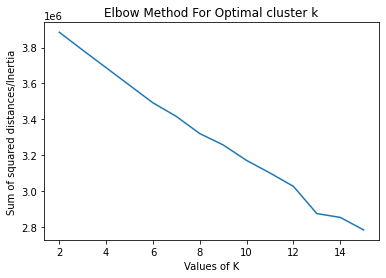

In [12]:
from sklearn.cluster import KMeans
sum_of_squared_dist = list()
k=range(2,16)
for cluster in k:
 kmeans = KMeans(n_clusters=cluster)
 kmeans.fit(diabetes_df_dropped)
 sum_of_squared_dist.append(kmeans.inertia_)
plt.plot(k,sum_of_squared_dist)
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal cluster k')
plt.savefig('Elbow method diabetes')
plt.show()